## Практическое задание 6. Градиентный бустинг ~~своими руками~~

Поздравляю! Это финальное упражнение в нашем курсе. Проявите все своё старание, терпение и опыт, чтобы выполнить его.  
Теперь вы многое знаете из машинного обучения и для вас не составит сложности попробовать разные алгоритмы, новые библиотеки и применить их к реальной задаче.

__Задание 1. (0.5 балла)__

Мы будем использовать данные соревнования [Home Credit Default Risk](https://www.kaggle.com/c/home-credit-default-risk/data).  

* Загрузите таблицу **application_train.csv**;
* Запишите в Y столбец с целевой переменной;
* Удалите ненужные столбцы (для этого воспользуйтесь описанием);
* Определите тип столбцов и заполните пропуски - стратегия произвольная;
* Разбейте выборку в соотношении 70:30 с random_state=0.

Так как в данных значительный дисбаланс классов, в качестве метрики качества везде будем использовать площадь под precision-recall кривой.

In [1]:
import time
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score
from sklearn.impute import SimpleImputer

In [2]:
data = pd.read_csv("application_train.csv")
Y = data['TARGET']
data = data.drop(columns=['SK_ID_CURR', 'TARGET'])

for column in data.columns:
    if data[column].dtype == 'object':
        imputer = SimpleImputer(strategy='most_frequent')
    else:
        imputer = SimpleImputer(strategy='mean')
    data[column] = imputer.fit_transform(data[[column]])

In [3]:
cat_features = data.select_dtypes(include=['int', 'float']).columns.to_list()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data, Y, test_size=0.3, random_state=0)

__Задание 2. (1.5 балла)__

Также мы будем использовать две реализации градиентного бустинга: [LightGBM](https://lightgbm.readthedocs.io/en/stable/Python-API.html) и [Catboost](https://catboost.ai/en/docs/), которые вам необходимо самостоятельно изучить и установить, используя команды:  
`!pip install lightgb`  
`!pip install catboost`  
Обучите реализации градиентного бустинга LightGBM и Catboost на вещественных признаках без подбора параметров. 
Почему получилась заметная разница в качестве? 

В этом и последующих экспериментах необходимо измерять время обучения моделей.

In [5]:
X_train = X_train.select_dtypes(include=['float','int'])
X_test = X_test.select_dtypes(include=['float','int'])

In [8]:
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import time

start_time_lgb = time.time()
lgb_model = LGBMClassifier(n_jobs=-1)
lgb_model.fit(X_train, y_train)
lgb_train_time = time.time() - start_time_lgb

lgb_probs = lgb_model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, lgb_probs)
lgb_auc_pr = auc(recall, precision)
lgb_auc_roc = roc_auc_score(y_test, lgb_probs)

start_time_cat = time.time()
cat_model = CatBoostClassifier(verbose=0)
cat_model.fit(X_train, y_train)
cat_train_time = time.time() - start_time_cat

cat_probs = cat_model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, cat_probs)
cat_auc_pr = auc(recall, precision)
cat_auc_roc = roc_auc_score(y_test, cat_probs)

print(f"LightGBM - Время обучения: {lgb_train_time:.4f} секунд, AUC (PR): {lgb_auc_pr:.4f}, AUC (ROC): {lgb_auc_roc:.4f}")
print(f"CatBoost - Время обучения: {cat_train_time:.4f} секунд, AUC (PR): {cat_auc_pr:.4f}, AUC (ROC): {cat_auc_roc:.4f}")

LightGBM - Время обучения: 0.7287 секунд, AUC (PR): 0.1630, AUC (ROC): 0.6570
CatBoost - Время обучения: 13.8910 секунд, AUC (PR): 0.2202, AUC (ROC): 0.7171


__Задание 3. (2 балла)__

Подберите с CV=3 оптимальные параметры алгоритмов, изменяя:

* глубину деревьев;
* количество деревьев;
* темп обучения;
* оптимизируемый функционал.

Проанализируйте соотношения глубины и количества деревьев в зависимости от алгоритма.

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score

roc_scorer = make_scorer(roc_auc_score, needs_proba=True)

lgb_param_grid = {
    'num_leaves': [20, 31, 40],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'objective': ['binary']
}

cat_param_grid = {
    'depth': [4, 6, 8],
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'loss_function': ['Logloss']
}

lgb_model = LGBMClassifier()
lgb_grid = GridSearchCV(lgb_model, lgb_param_grid, cv=3, scoring=roc_scorer)
lgb_grid.fit(X_train, y_train)
best_lgb_params = lgb_grid.best_params_
best_lgb_score = lgb_grid.best_score_

cat_model = CatBoostClassifier(verbose=0)
cat_grid = GridSearchCV(cat_model, cat_param_grid, cv=3, scoring=roc_scorer)
cat_grid.fit(X_train, y_train)
best_cat_params = cat_grid.best_params_
best_cat_score = cat_grid.best_score_

print(f"Лучшие параметры для LightGBM: {best_lgb_params}, AUC-ROC: {best_lgb_score:.4f}")
print(f"Лучшие параметры для CatBoost: {best_cat_params}, AUC-ROC: {best_cat_score:.4f}")

Лучшие параметры для LightGBM: {'learning_rate': 0.01, 'n_estimators': 100, 'num_leaves': 20, 'objective': 'binary'}, AUC-ROC: 0.6093
Лучшие параметры для CatBoost: {'depth': 2, 'iterations': 100, 'learning_rate': 0.01, 'loss_function': 'Logloss'}, AUC-ROC: 0.5871


__Задание 4. (3.5 балла)__

Добавьте категориальные признаки к вещественным следующими способами:

* как OHE признаки;
* как счетчики со сглаживанием.

При подсчете счетчиков запрещается использование циклов. 

На получившихся датасетах подберите параметры у каждого из алгоритмов. Как меняется время, необходимое для обучения модели в зависимости от способа кодирования? Сравните полученные результаты с встроенными методами обработки категориальных признаков. 

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import make_scorer, roc_auc_score
import time
import warnings
warnings.filterwarnings("ignore")

In [19]:
data = pd.read_csv('application_train.csv')
Y = data['TARGET']
columns_to_drop = ['SK_ID_CURR', 'TARGET']
data = data.drop(columns=columns_to_drop)

for col in data.columns:
    if data[col].dtype == 'object':
        data[col].fillna(data[col].mode()[0], inplace=True)
    else:
        data[col].fillna(data[col].mean(), inplace=True)

X_train, X_test, y_train, y_test = train_test_split(data, Y, test_size=0.3, random_state=0)
X_train_num = X_train.select_dtypes(include=['int', 'float'])
X_test_num = X_test.select_dtypes(include=['int', 'float'])

ohe = OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')
X_train_ohe = ohe.fit_transform(X_train.select_dtypes(include=['object']))
X_test_ohe = ohe.transform(X_test.select_dtypes(include=['object']))
X_train_combined_ohe = pd.concat([X_train_num.reset_index(drop=True), pd.DataFrame(X_train_ohe)], axis=1)
X_test_combined_ohe = pd.concat([X_test_num.reset_index(drop=True), pd.DataFrame(X_test_ohe)], axis=1)

target_encoder = TargetEncoder(cols=X_train.select_dtypes(include=['object']).columns)
X_train_encoded = target_encoder.fit_transform(X_train.select_dtypes(include=['object']), y_train)
X_test_encoded = target_encoder.transform(X_test.select_dtypes(include=['object']))
X_train_combined_encoded = pd.concat([X_train_num.reset_index(drop=True), X_train_encoded.reset_index(drop=True)], axis=1)
X_test_combined_encoded = pd.concat([X_test_num.reset_index(drop=True), X_test_encoded.reset_index(drop=True)], axis=1)

start_time = time.time()
lgb_model_ohe = LGBMClassifier()
lgb_param_grid = {'num_leaves': [20, 31, 40], 'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.05, 0.1]}
lgb_grid_ohe = GridSearchCV(lgb_model_ohe, lgb_param_grid, cv=3,n_jobs=1, scoring=make_scorer(roc_auc_score, needs_proba=True))
lgb_grid_ohe.fit(X_train_combined_ohe, y_train)
lgb_time_ohe = time.time() - start_time

start_time = time.time()
lgb_model_encoded = LGBMClassifier()
lgb_grid_encoded = GridSearchCV(lgb_model_encoded, lgb_param_grid, cv=3,n_jobs=1, scoring=make_scorer(roc_auc_score, needs_proba=True))
lgb_grid_encoded.fit(X_train_combined_encoded, y_train)
lgb_time_encoded = time.time() - start_time

start_time = time.time()
cat_model_ohe = CatBoostClassifier(verbose=0)
cat_param_grid = {'depth': [4, 6, 8], 'iterations': [100, 200, 300], 'learning_rate': [0.01, 0.05, 0.1]}
cat_grid_ohe = GridSearchCV(cat_model_ohe, cat_param_grid, cv=3,n_jobs=1, scoring=make_scorer(roc_auc_score, needs_proba=True))
cat_grid_ohe.fit(X_train_combined_ohe, y_train)
cat_time_ohe = time.time() - start_time

start_time = time.time()
cat_model_encoded = CatBoostClassifier(verbose=0)
cat_grid_encoded = GridSearchCV(cat_model_encoded, cat_param_grid, cv=3,n_jobs=1, scoring=make_scorer(roc_auc_score, needs_proba=True))
cat_grid_encoded.fit(X_train_combined_encoded, y_train)
cat_time_encoded = time.time() - start_time

print(f"Лучшие параметры для LightGBM с OHE: {lgb_grid_ohe.best_params_}, AUC-ROC: {lgb_grid_ohe.best_score_:.4f}, Время: {lgb_time_ohe:.4f} секунд")
print(f"Лучшие параметры для LightGBM со счетчиками: {lgb_grid_encoded.best_params_}, AUC-ROC: {lgb_grid_encoded.best_score_:.4f}, Время: {lgb_time_encoded:.4f} секунд")
print(f"Лучшие параметры для CatBoost с OHE: {cat_grid_ohe.best_params_}, AUC-ROC: {cat_grid_ohe.best_score_:.4f}, Время: {cat_time_ohe:.4f} секунд")
print(f"Лучшие параметры для CatBoost со счетчиками: {cat_grid_encoded.best_params_}, AUC-ROC: {cat_grid_encoded.best_score_:.4f}, Время: {cat_time_encoded:.4f} секунд")

Лучшие параметры для LightGBM с OHE: {'learning_rate': 0.05, 'n_estimators': 100, 'num_leaves': 20}, AUC-ROC: 0.6468, Время: 1.8667 секунд
Лучшие параметры для LightGBM со счетчиками: {'learning_rate': 0.05, 'n_estimators': 100, 'num_leaves': 20}, AUC-ROC: 0.7040, Время: 1.6029 секунд
Лучшие параметры для CatBoost с OHE: {'depth': 4, 'iterations': 100, 'learning_rate': 0.05}, AUC-ROC: 0.6439, Время: 5.0678 секунд
Лучшие параметры для CatBoost со счетчиками: {'depth': 4, 'iterations': 100, 'learning_rate': 0.05}, AUC-ROC: 0.7257, Время: 4.9208 секунд


__Задание 5. (1 балл)__

Реализуйте блендинг подобранных в предыдущем задании моделей и сравните качество.

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import roc_auc_score

lgb_best_ohe = lgb_grid_ohe.best_estimator_
lgb_best_encoded = lgb_grid_encoded.best_estimator_
cat_best_ohe = cat_grid_ohe.best_estimator_
cat_best_encoded = cat_grid_encoded.best_estimator_

stacking_model = StackingClassifier(
    estimators=[
        ('lgb_ohe', lgb_best_ohe),
        ('lgb_encoded', lgb_best_encoded),
        ('cat_ohe', cat_best_ohe),
        ('cat_encoded', cat_best_encoded)
    ],
    final_estimator=LogisticRegression(),
    cv=3
)

stacking_model.fit(X_train_combined_encoded, y_train)

stacking_pred = stacking_model.predict_proba(X_test_combined_encoded)[:, 1]
stacking_auc = roc_auc_score(y_test, stacking_pred)

print(f"Качество блендинга (AUC-ROC): {stacking_auc:.4f}")

Качество блендинга (AUC-ROC): 0.7267


__Задание 6. (1.5 балла)__

В задании 3 вы подобрали гиперпараметры для LightGBM и CatBoost на вещественных признаках. Визуализируйте важности признаков, посчитанные этими алгоритмами, в виде горизонтального bar-plot (отсортируйте признаки по убыванию важности, подпишите названия признаков по оси y).

Для каждого из двух алгоритмов удалите неважные признаки (обычно по bar-plot хорошо видно порог на важность, с которого начинается хвост неважных признаков) и обучите ту же модель на получившихся данных. Сильно ли упало качество при удалении признаков, которые модель считает неважными?

In [21]:
import shap
import matplotlib.pyplot as plt

In [22]:
y_pred_lgb_encoded = lgb_grid_encoded.best_estimator_.predict_proba(X_test_combined_encoded)[:, 1]
auc_lgb_encoded = roc_auc_score(y_test, y_pred_lgb_encoded)

y_pred_lgb_ohe = lgb_grid_ohe.best_estimator_.predict_proba(X_test_combined_ohe)[:, 1]
auc_lgb_ohe = roc_auc_score(y_test, y_pred_lgb_ohe)

y_pred_cat_ohe = cat_grid_ohe.best_estimator_.predict_proba(X_test_combined_ohe)[:, 1]
auc_cat_ohe = roc_auc_score(y_test, y_pred_cat_ohe)

y_pred_cat_encoded = cat_grid_encoded.best_estimator_.predict_proba(X_test_combined_encoded)[:, 1]
auc_cat_encoded = roc_auc_score(y_test, y_pred_cat_encoded)

print(f'AUC for LightGBM (Encoded): {auc_lgb_encoded:.4f}')
print(f'AUC for LightGBM (OHE): {auc_lgb_ohe:.4f}')
print(f'AUC for CatBoost (OHE): {auc_cat_ohe:.4f}')
print(f'AUC for CatBoost (Encoded): {auc_cat_encoded:.4f}')

AUC for LightGBM (Encoded): 0.7103
AUC for LightGBM (OHE): 0.7020
AUC for CatBoost (OHE): 0.7273
AUC for CatBoost (Encoded): 0.7233


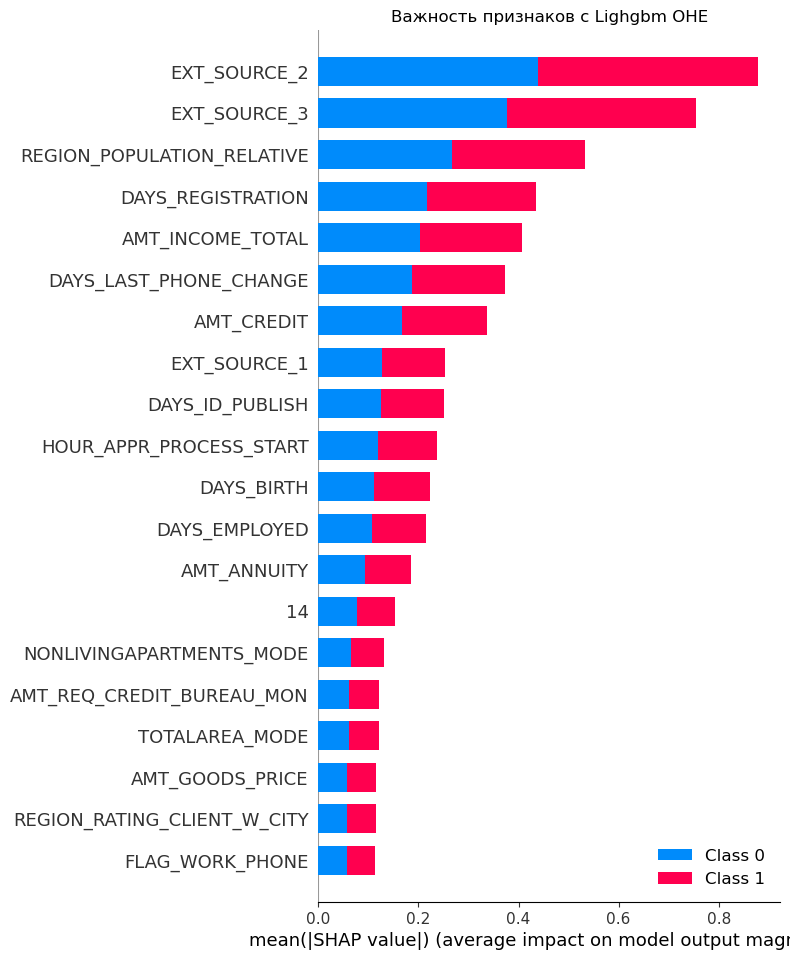

In [30]:
best_cat_model = lgb_grid_ohe.best_estimator_
explainer = shap.TreeExplainer(best_cat_model)
shap_values = explainer.shap_values(X_test_combined_ohe)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_combined_ohe, plot_type="bar", show=False)
plt.title('Важность признаков с Lighgbm OHE')
plt.show()

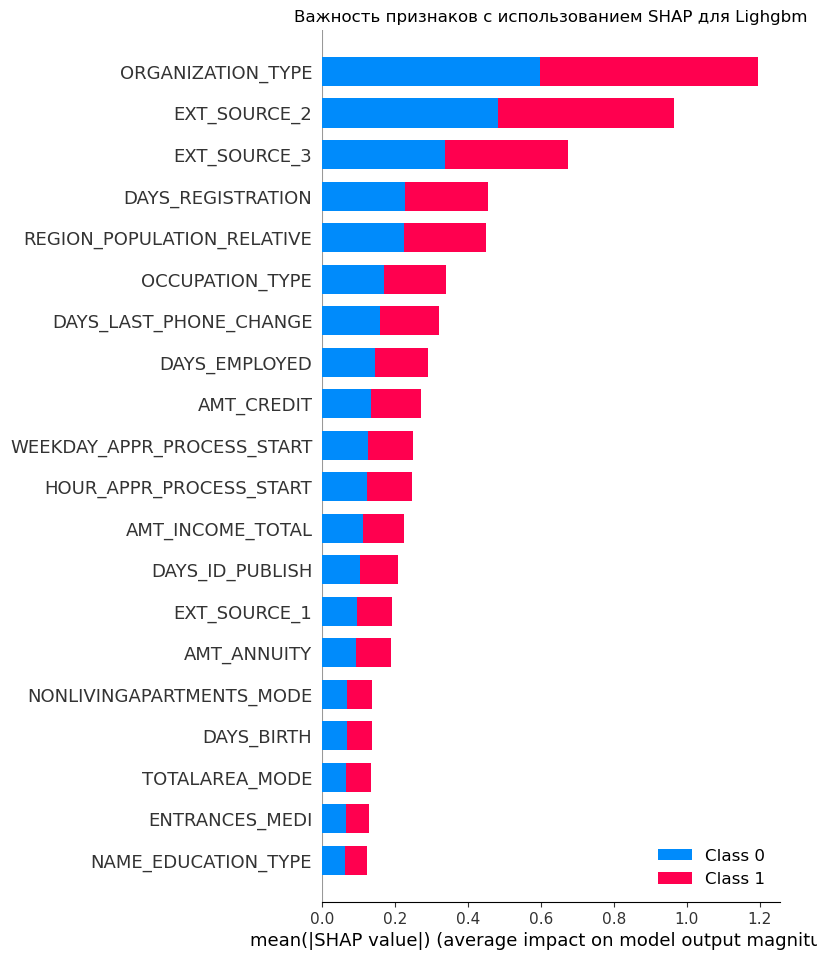

In [23]:
best_cat_model = lgb_grid_encoded.best_estimator_
explainer = shap.TreeExplainer(best_cat_model)
shap_values = explainer.shap_values(X_train_combined_encoded)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_train_combined_encoded, plot_type="bar", show=False)
plt.title('Важность признаков с использованием SHAP для Lighgbm')
plt.show()

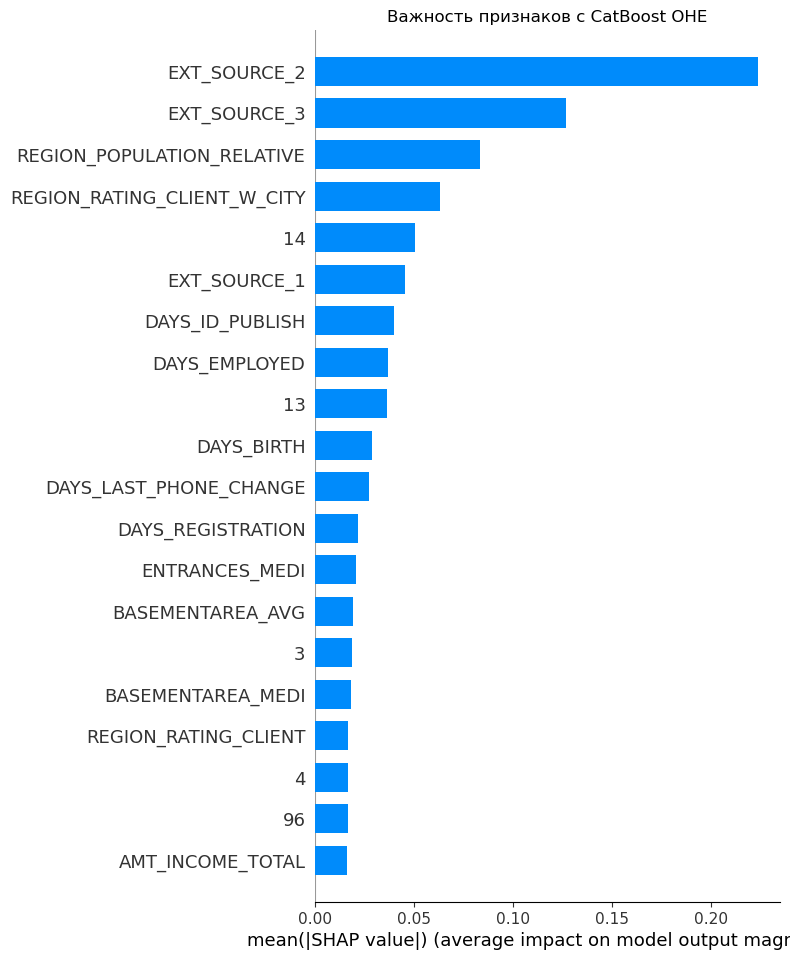

In [24]:
best_cat_model = cat_grid_ohe.best_estimator_
explainer = shap.TreeExplainer(best_cat_model)
shap_values = explainer.shap_values(X_train_combined_ohe)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_train_combined_ohe, plot_type="bar", show=False)
plt.title('Важность признаков c CatBoost OHE')
plt.show()

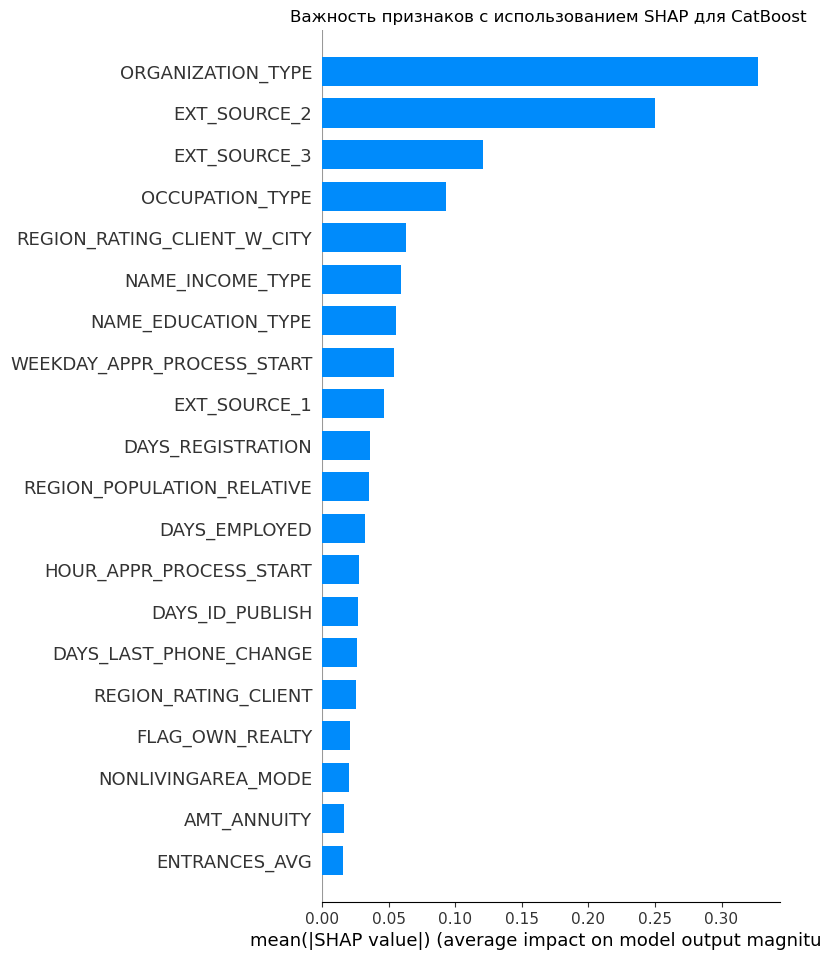

In [25]:
best_cat_model = cat_grid_encoded.best_estimator_
explainer = shap.TreeExplainer(best_cat_model)
shap_values = explainer.shap_values(X_train_combined_encoded)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_train_combined_encoded, plot_type="bar", show=False)
plt.title('Важность признаков с использованием SHAP для CatBoost ')
plt.show()